Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Reading Raster Image
Creating input matrix
Original Shape (401, 410, 12)
New Shape: (164410, 12)
Running K Means 
K = 5
Fitting K Means
Creating clusters
Clusters created
Time: 6.781682729721069
Creating Color Map
Saving color map image
Comparing with cluster number:  0
Reading Raster Image
Creating input matrix
Original Shape (401, 410, 1)
New Shape: (164410, 1)
(164410, 1)
1.0
Unique values in the given truth layer:  [1. 2.]
Precision is: 0.04764586130722918 %
Recall is:  0.11314544332441884 %
Accuracy(IOU) is:  80.05778237333494 %
True_Positive:  11
False_Positive:  23076
True_Negative:  131612
False_Negative:  9711
Comparing with cluster number:  1
Reading Raster Image
Creating input matrix
Original Shape (401, 410, 1)
New Shape: (164410, 1)
(164410, 1)
1.0
Unique values in the given truth layer:  [1. 2.]
Precision is: 1.9520494280405631 %
Recall is:  8

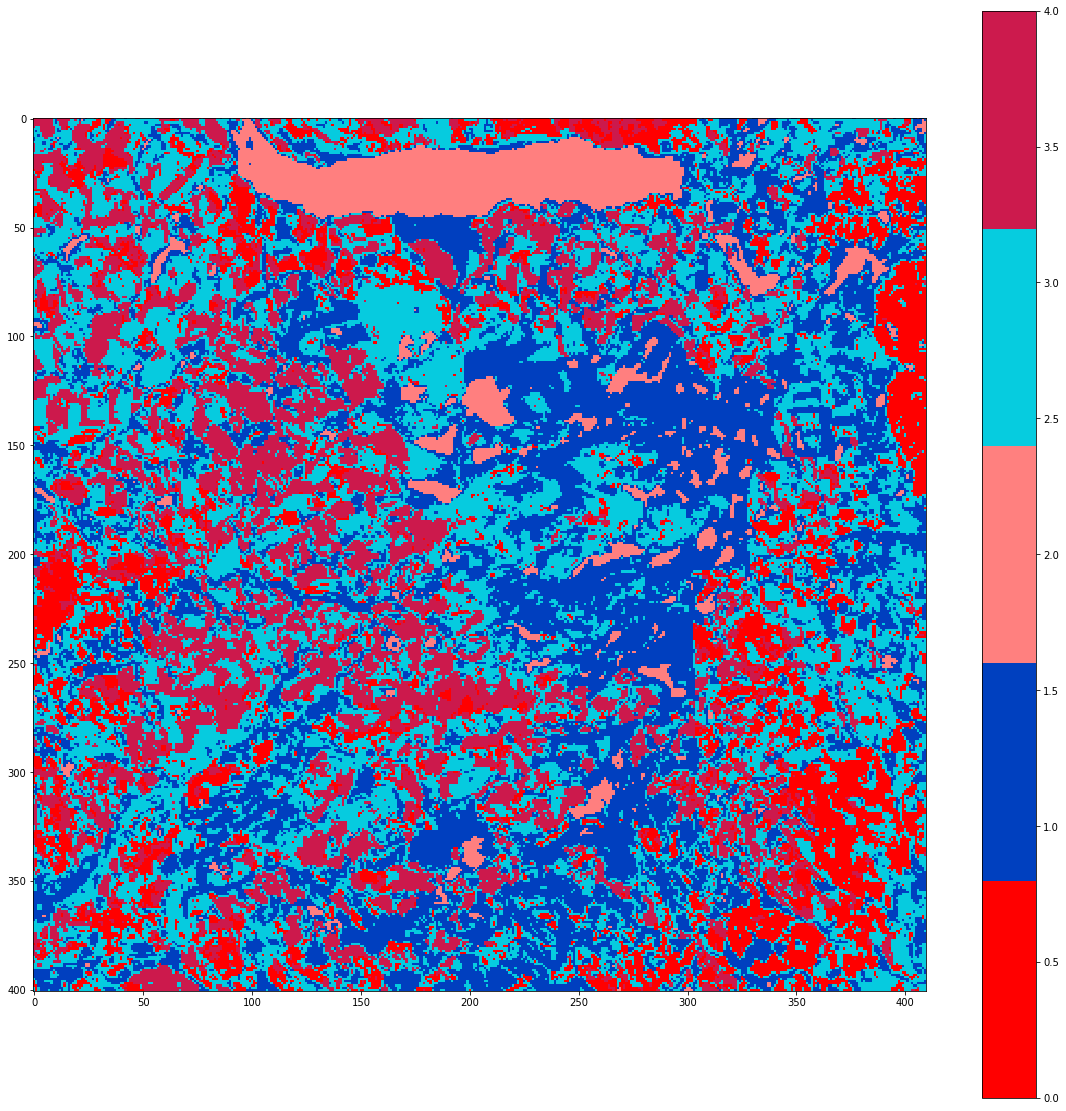

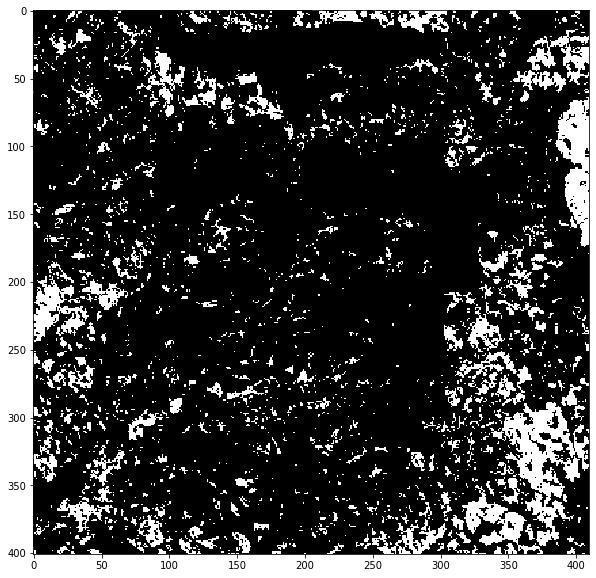

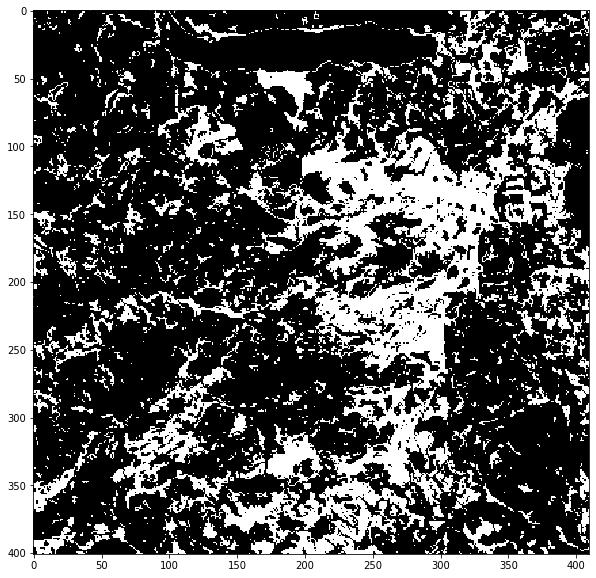

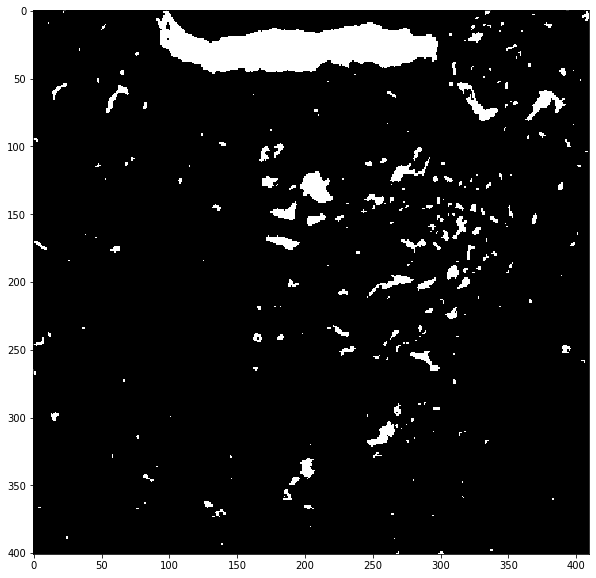

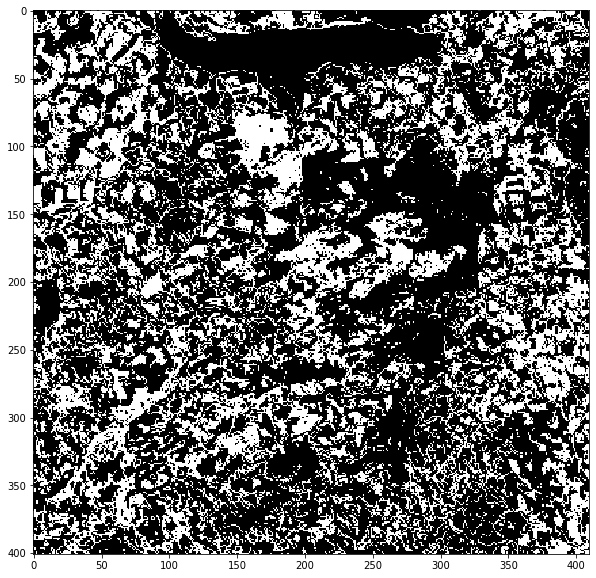

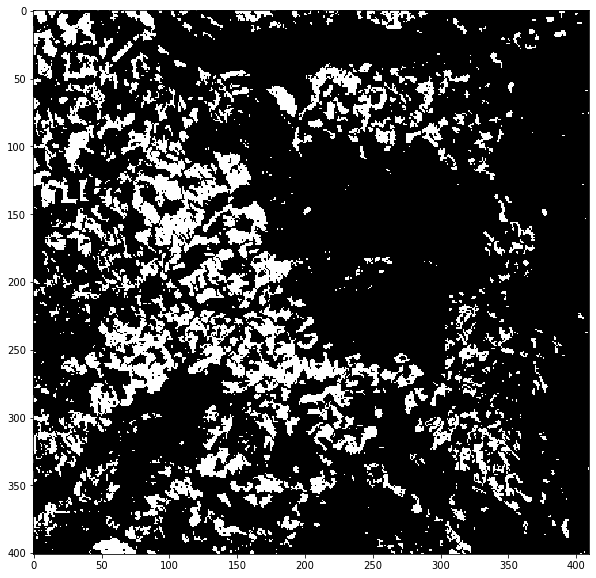

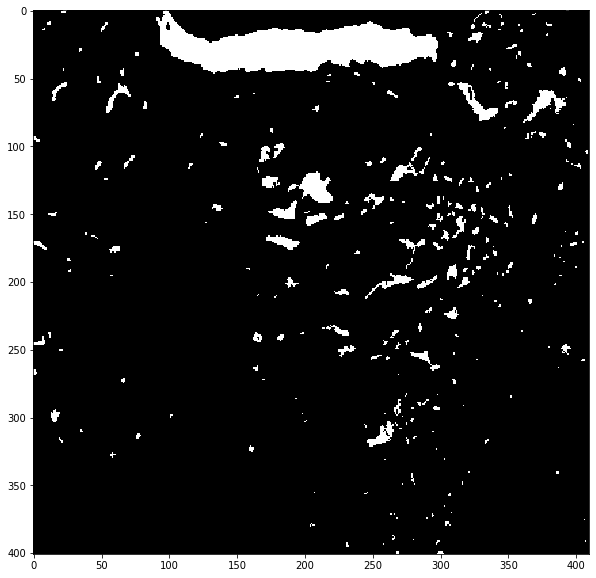

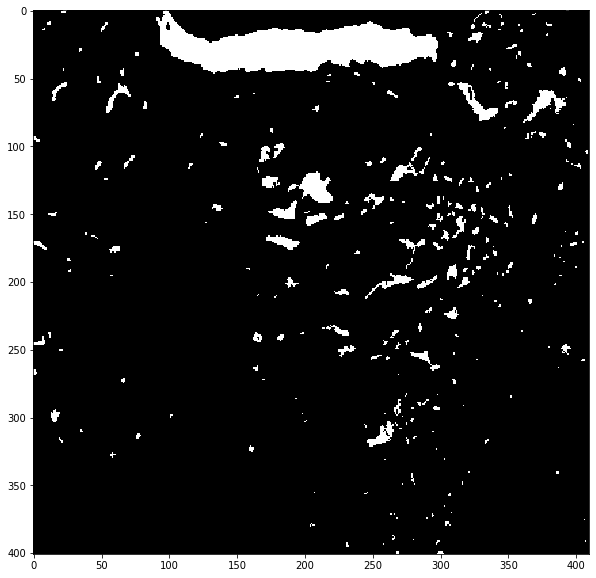

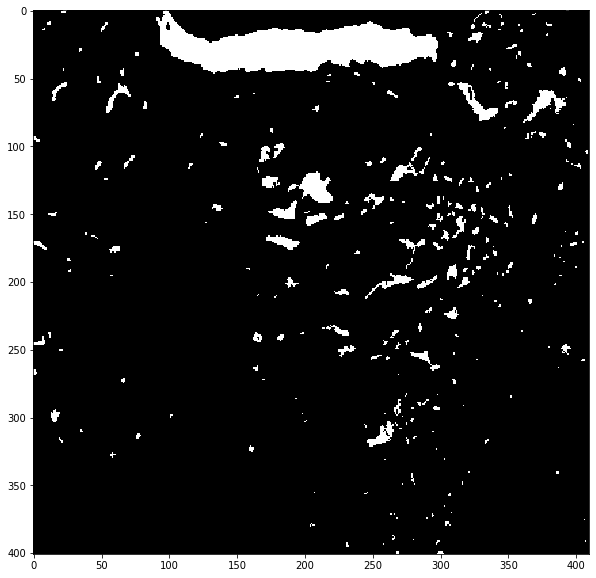

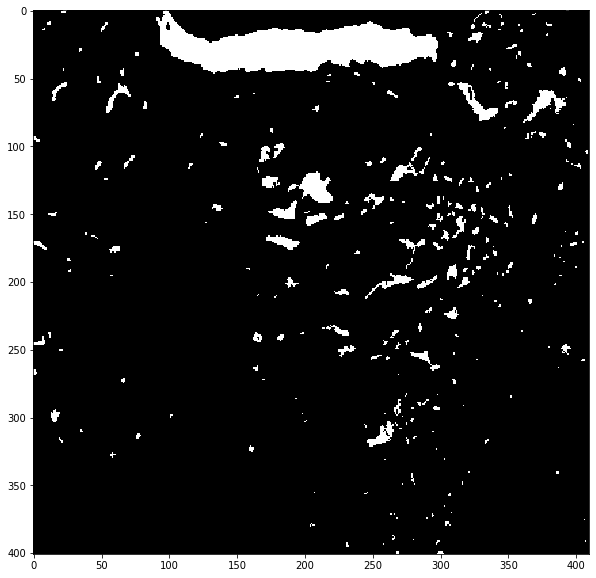

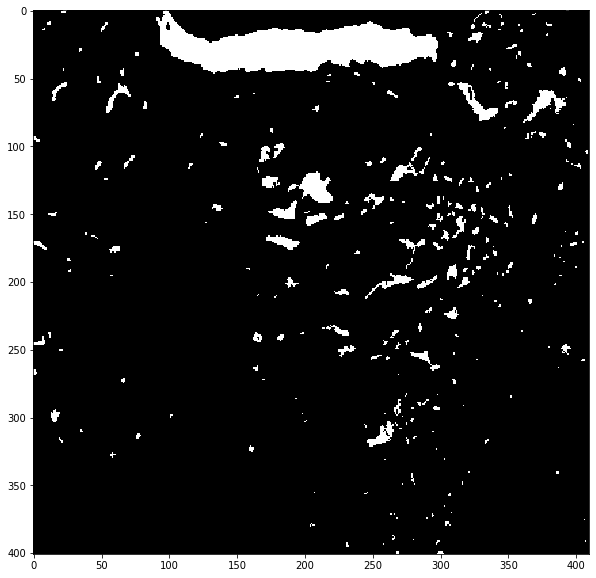

In [85]:
#Comparing K_MEan with truth data
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
from sklearn.cluster import KMeans
import numpy as np
from osgeo import gdal, gdal_array
import sys
import math
import time
import os

#colab imorts
from google.colab import drive
from google.colab.patches import cv2_imshow # because cv2 doesnot work in colab

gdal.UseExceptions()
gdal.AllRegister()


# mounting the google drive
drive.mount('/content/gdrive')


rawImagePath = "/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/"
colorMapImagePath = "/content/gdrive/My Drive/Color_Maps/"
imageName = "S2A.bin_4x.bin_sub"
imageExtension = ".bin"

image = rawImagePath + imageName + imageExtension

#Truth Data Layers
broadLeaf_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/BROADLEAF_SP.tif_project_4x.bin_sub.bin"
ccutbl_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CCUTBL_SP.tif_project_4x.bin_sub.bin"
conifer_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CONIFER_SP.tif_project_4x.bin_sub.bin"
exposed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/EXPOSED_SP.tif_project_4x.bin_sub.bin"
herb_grass_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/HERB_GRAS_SP.tif_project_4x.bin_sub.bin"
mixed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/MIXED_SP.tif_project_4x.bin_sub.bin"
rivers_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/RiversSP.tif_project_4x.bin_sub.bin"
shrub_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/SHRUB_SP.tif_project_4x.bin_sub.bin"
water_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/WATERSP.tif_project_4x.bin_sub.bin"
vri_s2_objid2="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s2_objid2.tif_project_4x.bin_sub.bin"
vri_s2_objid3="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s3_objid2.tif_project_4x.bin_sub.bin"

save_colormap_path="/content/gdrive/My Drive/K_Means_Color_Maps/K14/"

dir = '/content/gdrive/My Drive/Truth_Data/vri_rasterize_subset/subset'

# Params
K = 5
MAX_K = 20
init = 'k-means++'
n_init = 10
# number of processors to use (default 1, -1 uses all processors)
n_jobs = -1


#list containing the all the layers created from k-means
individual_layers=[]

def showImage(filepath):
    image = cv2.imread(filepath)
    plt.show(image)
    plt.show()


def readRasterImage(image):
    print("Reading Raster Image")
    image_ds = gdal.Open(image, gdal.GA_ReadOnly)
    return image_ds


def getInputMatrix(image_ds):
    image = np.zeros((image_ds.RasterYSize, image_ds.RasterXSize, image_ds.RasterCount),
                     gdal_array.GDALTypeCodeToNumericTypeCode(image_ds.GetRasterBand(1).DataType))
    print("Creating input matrix")
    for band in range(image.shape[2]):
        image[:, :, band] = image_ds.GetRasterBand(band + 1).ReadAsArray()

    print('Original Shape', image.shape)
    new_shape = (image.shape[0] * image.shape[1], image.shape[2])
    print("New Shape:", new_shape)
    X = image[:, :, :13].reshape(new_shape)

    return X, image


def runKMeans(K, X, image):
    start = time.time()
    print("Running K Means", "\nK =", K)
    k_means = KMeans(n_clusters=K, init=init, n_init=n_init,
                     n_jobs=n_jobs, verbose=1)
    print("Fitting K Means")
    k_means.fit(X)
    print("Creating clusters")
    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(image[:, :, 0].shape)
    print("Clusters created")
    stop = time.time()
    totalProcessTime = stop - start
    print("Time: " + str(totalProcessTime))
    return X_cluster


def createColorMap(X_cluster, K):
    plt.figure(figsize=(20, 20))
    colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0),
              (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    print("Creating Color Map")
    cm = LinearSegmentedColormap.from_list("Map", colors, N=K)
    plt.imshow(X_cluster, cmap=cm)
    plt.colorbar()
    plt.show
    print("Saving color map image")
    # plt.imsave(save_colormap_path + imageName +
    #            "k_7_colormap.png",  X_cluster, cmap=cm)


def elbow_method(image_2d, max_k):
    wcss = []
    for i in range(2, max_k):
        kmeans = KMeans(n_clusters=i, init='k-means++',
                        random_state=42)
        kmeans.fit(image_2d)
        wcss.append(kmeans.inertia_)

    x = [i for i in range(2, max_k)]
    plt.plot(x, wcss, '--bo')
    plt.xticks(x, x)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

'''
Function Description: Create an Individual Layer from the generated color map
'''
def create_individual_layer(c_no, colormap):
   colormap_ext =  np.zeros((colormap.shape[0], colormap.shape[1]))
   colormap_ext[:,:] = colormap[:,:]
   for index_x in range(colormap.shape[0]):
     for index_y in range(colormap.shape[1]):
       if(colormap_ext[index_x, index_y]==c_no):
         colormap_ext[index_x, index_y]=1
       
       else:
         colormap_ext[index_x, index_y]=0
   colors = [(0,0,0), (1,1,1)]
   cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
   plt.figure(figsize=(10, 10))
   plt.imshow(colormap_ext, cmap=cm)
  #  plt.imsave(save_colormap_path+str(c_no)+".png", colormap_ext, cmap=cm )
   individual_layers.append(colormap_ext) # append individual layer created to the list, so that it can be used later to compare with the truth data

'''
Function Description: Compare classes created by unsupervised method to the truth data
'''
def compare(layer_type, cluster_n):
  l_ds = readRasterImage(layer_type)
  X, l_img = getInputMatrix(l_ds)
  print(X.shape)
  print(X[0,0])
  water_X=np.zeros((l_img.shape[0], l_img.shape[1]))
  water_X = X.reshape(l_img[:,:,0].shape) #truth_data layer
  layer_k = np.zeros((l_img.shape[0], l_img.shape[1]))
  layer_k = individual_layers[cluster_n] #layer generated from the k_means
  print('Unique values in the given truth layer: ',np.unique(water_X))
  for index_x in range(water_X.shape[0]):
    for index_y in range(water_X.shape[1]):
      if(water_X[index_x,index_y]==1.0):
        water_X[index_x,index_y]=0
      
      else:
        water_X[index_x,index_y]=1
  colors = [(0,0,0), (1,1,1)]
  cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
  plt.figure(figsize=(10, 10))
  plt.imshow(water_X, cmap=cm)

  #get the stats
  stat(water_X, layer_k)

   

'''
Function Description : Return Stats over the layer generated from K-Means to the the truth data layer 
'''
def stat(truth_layer, generated_layer):
  #counters for the score
  true_positive=0
  true_negative=0
  false_negative=0
  false_positive=0

  for index_x in range(truth_layer.shape[0]):
    for index_y in range(truth_layer.shape[1]):
      if(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==1):
        true_positive+=1
      elif(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==0):
        false_negative+=1
      elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==1):
        false_positive+=1
      elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==0):
        true_negative+=1

  #compute the stats
  precision = true_positive/(true_positive+false_positive)
  print('Precision is:', precision*100, '%')

  recall = true_positive/(true_positive +false_negative)
  print('Recall is: ', recall*100, '%')

  iou = (true_positive + true_negative)/(true_positive + true_negative + false_negative + false_positive)
  print('Accuracy(IOU) is: ', iou*100, '%')

  print('True_Positive: ',true_positive)
  print('False_Positive: ',false_positive)
  print('True_Negative: ',true_negative)
  print('False_Negative: ',false_negative)





def run():
    showImage(image)
    img_ds = readRasterImage(image)
    X, img = getInputMatrix(img_ds)
    X_cluster = runKMeans(K, X, img)

    # original_img = np.zeros((img.shape[0], img.shape[1], 3))
    # for b in range(2,5):
    #    original_img[:, :, 4-b] = img[:, :, b]

    # plt.figure(figsize=(7,7))
    # plt.imshow(original_img)  
    # plt.imsave(save_colormap_path+'original.png', original_img)

    createColorMap(X_cluster, K)
    #create an individual layers for each of the cluster
    create_individual_layer(0, X_cluster)
    create_individual_layer(1, X_cluster)
    create_individual_layer(2, X_cluster)
    create_individual_layer(3, X_cluster)
    create_individual_layer(4, X_cluster)
    # create_individual_layer(5, X_cluster)
    # create_individual_layer(6, X_cluster)
    # create_individual_layer(7, X_cluster)
    # create_individual_layer(8, X_cluster)
    # create_individual_layer(9, X_cluster)
    # create_individual_layer(10, X_cluster)
    # create_individual_layer(11, X_cluster)
    # create_individual_layer(12, X_cluster)
    # create_individual_layer(13, X_cluster)
    # create_individual_layer(14, X_cluster)
    # create_individual_layer(15, X_cluster)
    # create_individual_layer(16, X_cluster)
    # create_individual_layer(17, X_cluster)

    # compare(broadLeaf_sp,2 ) #compare the clusters with the truth data water
    #compare(ccutbl_sp,2)
    # compare(conifer_sp,2)
    # compare(exposed_sp,2)
    # compare(herb_grass_sp,2)
    # compare(mixed_sp,2)
    # compare(shrub_sp,2)
    layer='BCLCS_LEVE.bin_sub.bin'
    for n in range(K):
      print('Comparing with cluster number: ', n)
      compare(os.path.join(dir,layer ), n)

    print("done")


run()



Mounted at /content/gdrive
Unique values in the given truth layer:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 14. 16. 17. 20. 22. 25.
 31.]
LAND_COVER.bin_sub.bin


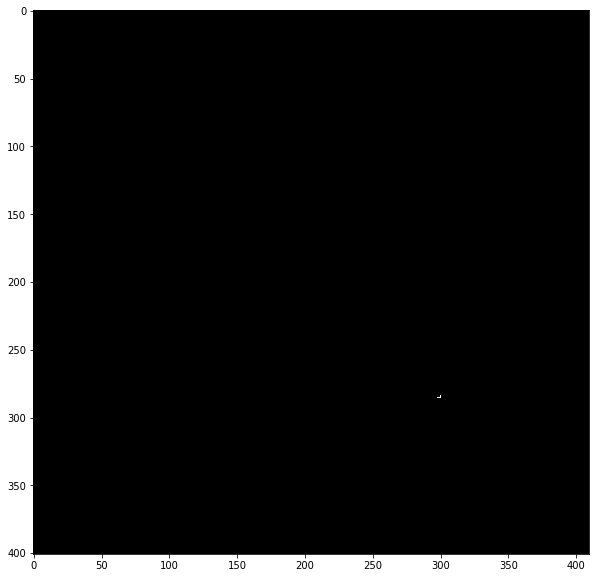

In [113]:
#Studying the new truth data
#Comparing K_MEan with truth data
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
from sklearn.cluster import KMeans
import numpy as np
from osgeo import gdal, gdal_array
import sys
import math
import time
import os

#colab imorts
from google.colab import drive
from google.colab.patches import cv2_imshow # because cv2 doesnot work in colab

gdal.UseExceptions()
gdal.AllRegister()


# mounting the google drive
drive.mount('/content/gdrive', force_remount=True)
#truth data path
dir = '/content/gdrive/My Drive/Truth_Data/vri_rasterize_subset/subset'

def show_all_truth_data_figures():
    for file in os.listdir(dir):
      if file.endswith(".bin"):
        image_ = os.path.join(dir, file)
        image_ds = gdal.Open(image_, gdal.GA_ReadOnly)
        image = np.zeros((image_ds.RasterYSize, image_ds.RasterXSize, image_ds.RasterCount),
                        gdal_array.GDALTypeCodeToNumericTypeCode(image_ds.GetRasterBand(1).DataType))
        for band in range(image.shape[2]):
            image[:, :, band] = image_ds.GetRasterBand(band + 1).ReadAsArray()

    
        new_shape = (image.shape[0] * image.shape[1], image.shape[2])

        X = image[:, :, :13].reshape(new_shape)
        l_img = image
        water_X=np.zeros((l_img.shape[0], l_img.shape[1]))
        water_X = X.reshape(l_img[:,:,0].shape) #truth_data layer
        layer_k = np.zeros((l_img.shape[0], l_img.shape[1]))
        #  layer_k = individual_layers[cluster_n] #layer generated from the k_means
        # print('Unique values in the given truth layer: ',np.unique(water_X))
        for index_x in range(water_X.shape[0]):
          for index_y in range(water_X.shape[1]):
            if(water_X[index_x,index_y]==10.0):
              water_X[index_x,index_y]=0
            
            else:
              water_X[index_x,index_y]=1
        colors = [(0,0,0), (1,1,1)]
        cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
        plt.figure(figsize=(10, 10))
        print(file)
        plt.rcParams.update({'figure.max_open_warning': 0})
        plt.imshow(water_X, cmap=cm)


def show_individual_truth_data_layer(file):
        image_ = os.path.join(dir, file)
        image_ds = gdal.Open(image_, gdal.GA_ReadOnly)
        image = np.zeros((image_ds.RasterYSize, image_ds.RasterXSize, image_ds.RasterCount),
                        gdal_array.GDALTypeCodeToNumericTypeCode(image_ds.GetRasterBand(1).DataType))
        for band in range(image.shape[2]):
            image[:, :, band] = image_ds.GetRasterBand(band + 1).ReadAsArray()

    
        new_shape = (image.shape[0] * image.shape[1], image.shape[2])

        X = image[:, :, :13].reshape(new_shape)
        l_img = image
        water_X=np.zeros((l_img.shape[0], l_img.shape[1]))
        water_X = X.reshape(l_img[:,:,0].shape) #truth_data layer
        layer_k = np.zeros((l_img.shape[0], l_img.shape[1]))
        #  layer_k = individual_layers[cluster_n] #layer generated from the k_means
        print('Unique values in the given truth layer: ',np.unique(water_X))
        for index_x in range(water_X.shape[0]):
          for index_y in range(water_X.shape[1]):
            if(water_X[index_x,index_y]!=12.0):
              water_X[index_x,index_y]=0
            
            else:
              water_X[index_x,index_y]=1
        colors = [(0,0,0), (1,1,1)]
        cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
        plt.figure(figsize=(10, 10))
        print(file)
        plt.rcParams.update({'figure.max_open_warning': 0})
        plt.imshow(water_X, cmap=cm)


def run():
  show_individual_truth_data_layer('LAND_COVER.bin_sub.bin')


run()  
